In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Markdown

# Concrete Compressive Strength Estimation

In this example we will look at estimating concrete compressive strength using some features such as the concentration of cement in the mix, the age of the concrete etc. This data was used in the following research paper from 1998, [Modeling of strength of high-performance concrete using artificial neural networks](https://www.sciencedirect.com/science/article/pii/S0008884698001653), and is available on Amathuba under Module B2: Supervised Learning > Datasets > concrete_data.csv

Understanding the data is always an important step and it might be useful to read through the research paper to understand some of their thought processes and decisions. For example, why were these input features selected for collection? The variables in this dataset have the following basic information about them.

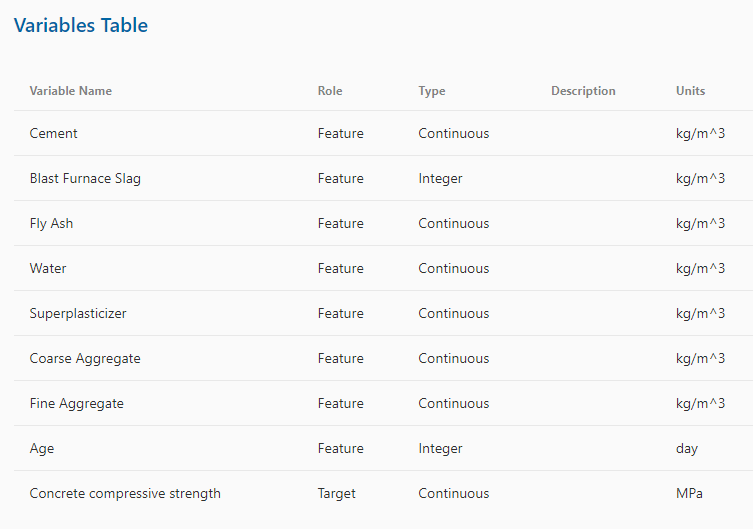

You can get more information from the research paper if needed. Once you know what the data is about we should import the dataset into a form we can work with.

In [3]:
# We can use the Pandas library to handle data efficiently. They include methods to import from a csv file.
dataset = pd.read_csv("../data/concrete_data.csv", header = 0)

Let's have a quick look at what the data looks like

In [4]:
dataset

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


So there are 1030 examples in total. From the research paper they indicate that compressive strength is the target variable, therefore the rest are input features. We can split the dataset into separate dataframes for the inputs and targets to make it a bit easier to work with.

In [5]:
#Split the dataframe into inputs, X, and targets, y.
X = dataset.loc[:,:"Age"]
print("X has dimensions {}. This indicates 1030 rows (examples), 8 columns (input features)".format(X.shape))

y = dataset.loc[:,"Strength"]
print("y has dimensions {}. This indicates 1030 rows (examples), but only 1 column (target feature)".format(y.shape))

X has dimensions (1030, 8). This indicates 1030 rows (examples), 8 columns (input features)
y has dimensions (1030,). This indicates 1030 rows (examples), but only 1 column (target feature)


We can try plot single features with respect to the target to have a visualisation of how they might correlate.

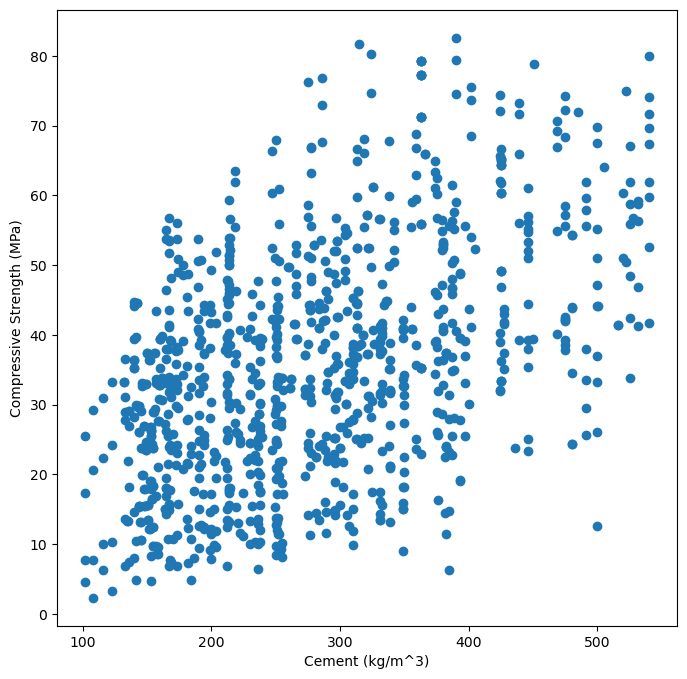

In [6]:
fig = plt.figure(figsize=(8,8))

plt.scatter(X['Cement'], y)

plt.xlabel('Cement (kg/m^3)')
plt.ylabel('Compressive Strength (MPa)')
plt.show()

The "cement" feature does not seem particularly useful on it's own, but perhaps it is useful in combination with other features. Try look at other features and see how they relate to the target variable.

In [7]:
# You can use this block to play around with your own plots

We could train the model on all of the collected data, however, more data would need to be collected to give a better estimate of how it might perform on unseen data. Instead of using all of the available data for training, we could split it into two sets, and make sure that one of the sets is only used for evaluation and never used as pat of the model optimization. The size of the splits might depend on how much data you have available. For example, if you split your data such that only 60% is used for training, 40% for testing, you might have a good estimate of generalisation performance, however you might not have sufficient data to optimize the model for a small dataset. Conversely, having too much training data and not enough test data might skew the estimate of the generalisation performance. We will talk more about these issues later on.

Most libraries offer methods to automatically create splits in our data set which makes things easier to keep track of.

In [28]:
# The test set produced by random_state=1, which will be universal to everyone.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.91, random_state=1)

In [29]:
print("Training input data, X_train, has a shape of {}".format(X_train.shape))
print("Training target data, y_train, has a shape of {}".format(y_train.shape))
print("Testing input data, X_test, has a shape of {}".format(X_test.shape))
print("Testing target data, y_test, has a shape of {}".format(y_test.shape))

Training input data, X_train, has a shape of (92, 8)
Training target data, y_train, has a shape of (92,)
Testing input data, X_test, has a shape of (938, 8)
Testing target data, y_test, has a shape of (938,)


We can plot the data for a single feature again, just to visualise how the data has been split between training and test sets.

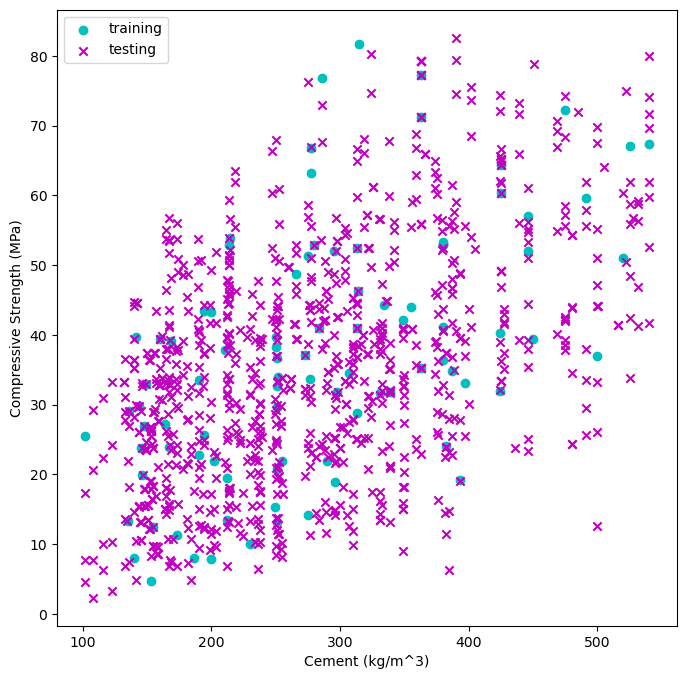

In [30]:
fig = plt.figure(figsize=(8,8))

# Plot training and test sets
plt.scatter(X_train['Cement'], y_train, color='c', label='training')
plt.scatter(X_test['Cement'], y_test, color='m', label='testing', marker='x')

plt.xlabel('Cement (kg/m^3)')
plt.ylabel('Compressive Strength (MPa)')
plt.legend()
plt.show()

At this stage we could try build a linear regression model that takes in all of the input features and tries to produce predicted compressive strength values.

In [31]:
# Define a linear regression model.
lin_reg = LinearRegression()
# Train it on the data set aside for learning.
lin_reg.fit(X_train, y_train)
# Test it on the data set aside for testing.
score = lin_reg.score(X_test, y_test)

display(Markdown('We should expect a linear model to perform poorly, and this case the score is:'))
display(Math(r'r^2 = {}'.format(score.round(2))))


We should expect a linear model to perform poorly, and this case the score is:

<IPython.core.display.Math object>

So what can we do to improve performance? Perhaps we need to try a more complex model, perhaps we need to look closer at which features are valuable.